Epoch 0: Train MCC = 0.8551, Val MCC = 0.9057
Epoch 10: Train MCC = 0.8676, Val MCC = 0.9118
Epoch 20: Train MCC = 0.8740, Val MCC = 0.9244
Epoch 30: Train MCC = 0.8752, Val MCC = 0.9202
Epoch 40: Train MCC = 0.8729, Val MCC = 0.9331
Epoch 50: Train MCC = 0.8760, Val MCC = 0.9248
Epoch 60: Train MCC = 0.8770, Val MCC = 0.9248
Epoch 70: Train MCC = 0.8760, Val MCC = 0.9248
Epoch 80: Train MCC = 0.8797, Val MCC = 0.9091
Epoch 90: Train MCC = 0.8773, Val MCC = 0.9334

Training finished. Loaded weights with best Val MCC: 0.9377


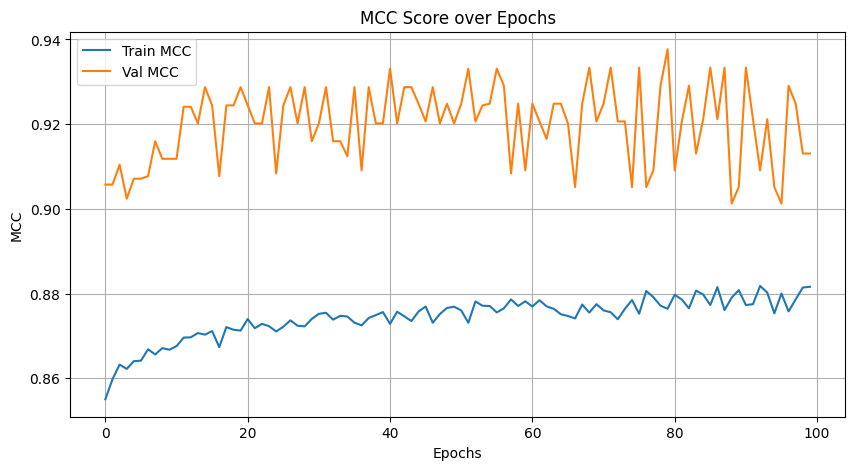

Predictions saved to test.txt.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# set random seed
seed_value = 4
random.seed(seed_value)
np.random.seed(seed_value)

# --- 1. Data Loading and Preprocessing ---
# Load training and testing datasets
train_data = pd.read_csv('train.dat', header=None).values
test_features = pd.read_csv('test.dat', header=None).values

# Separate labels (y) and features (X)
y_train_full = train_data[:, 0].reshape(-1, 1)
x_train_full = train_data[:, 1:]

# Normalize features using Z-score standardization (Zero-mean, Unit-variance)
# Note: Test data must be normalized using training set statistics to avoid data leakage
mean = x_train_full.mean(axis=0)
std = x_train_full.std(axis=0)

x_train_full = (x_train_full - mean) / std
x_test = (test_features - mean) / std

# Split dataset into Training (80%) and Validation (20%) sets
indices = np.arange(x_train_full.shape[0])
np.random.shuffle(indices)
split = int(0.9 * len(indices))

x_train, x_val = x_train_full[indices[:split]], x_train_full[indices[split:]]
y_train, y_val = y_train_full[indices[:split]], y_train_full[indices[split:]]

# Calculate class weights to address data imbalance (Pulsars are rare)
num_pos = np.sum(y_train == 1)
num_neg = np.sum(y_train == 0)
weight_pos = num_neg / num_pos  # Inverse frequency weighting for the positive class

# --- 2. Activation Functions and Metrics ---
def sigmoid(x):
    return 1 / (1 + np.exp(-np.clip(x, -500, 500)))

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

def compute_mcc(y_true, y_pred_prob):
    y_pred = (y_pred_prob > 0.8).astype(int)
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    
    num = (tp * tn) - (fp * fn)
    den = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    return num / den if den != 0 else 0 

# --- 3. Network Initialization ---
input_dim = 8
h1_dim = 128
h2_dim = 64
output_dim = 1

# Weights initialization: He Normal for ReLU layers, Xavier Normal for Sigmoid layer
W1 = np.random.randn(input_dim, h1_dim) * np.sqrt(2. / input_dim)
b1 = np.ones((1, h1_dim)) * 0.01  # Small positive bias to prevent 'dead' neurons
W2 = np.random.randn(h1_dim, h2_dim) * np.sqrt(2. / h1_dim)
b2 = np.ones((1, h2_dim)) * 0.01
W3 = np.random.normal(0, np.sqrt(2.0 / (h2_dim + output_dim)), (h2_dim, output_dim))
b3 = np.zeros((1, output_dim))

# Initialize Momentum velocity terms (initialized to zero)
vW1, vb1 = np.zeros_like(W1), np.zeros_like(b1)
vW2, vb2 = np.zeros_like(W2), np.zeros_like(b2)
vW3, vb3 = np.zeros_like(W3), np.zeros_like(b3)

# --- 4. Forward Propagation ---
def forward(x):
    z1 = np.dot(x, W1) + b1
    a1 = relu(z1)
    z2 = np.dot(a1, W2) + b2
    a2 = relu(z2)
    z3 = np.dot(a2, W3) + b3
    a3 = sigmoid(z3)
    return z1, a1, z2, a2, z3, a3

# --- 5. Training Hyperparameters ---
lr = 0.0005             # Learning rate
momentum = 0.9          # Momentum coefficient for smoother updates
epochs = 100            # Total training iterations
batch_size = 64         # Size of each mini-batch
num_samples = x_train.shape[0]

train_mccs = []
val_mccs = []
best_val_mcc = -1
best_weights = {}       # Dictionary to store the best model parameters 

# --- 6. Main Training Loop ---
for epoch in range(epochs):
    # Randomly shuffle training data at the start of each epoch
    indices = np.random.permutation(num_samples)
    X_shuffled = x_train[indices]
    y_shuffled = y_train[indices]
    
    # Mini-batch Gradient Descent
    for i in range(0, num_samples, batch_size):
        X_batch = X_shuffled[i : i + batch_size]
        y_batch = y_shuffled[i : i + batch_size]
        
        # A. Forward Pass
        z1, a1, z2, a2, z3, a3 = forward(X_batch)
        
        # B. Backpropagation with Class Weighting
        batch_weights = np.ones_like(y_batch)
        batch_weights[y_batch == 1] = weight_pos # Scale loss for rare positive samples
        
        # Output Layer Gradients
        dz3 = (a3 - y_batch) * batch_weights
        dW3 = np.dot(a2.T, dz3) / len(X_batch)
        db3 = np.mean(dz3, axis=0)
        
        # Hidden Layer 2 Gradients
        da2 = np.dot(dz3, W3.T)
        dz2 = da2 * relu_derivative(z2)
        dW2 = np.dot(a1.T, dz2) / len(X_batch)
        db2 = np.mean(dz2, axis=0)
        
        # Hidden Layer 1 Gradients
        da1 = np.dot(dz2, W2.T)
        dz1 = da1 * relu_derivative(z1)
        dW1 = np.dot(X_batch.T, dz1) / len(X_batch)
        db1 = np.mean(dz1, axis=0)
        
        # C. Momentum Update (v = m*v - lr*grad)
        vW3 = momentum * vW3 - lr * dW3
        vb3 = momentum * vb3 - lr * db3
        W3 += vW3; b3 += vb3
        
        vW2 = momentum * vW2 - lr * dW2
        vb2 = momentum * vb2 - lr * db2
        W2 += vW2; b2 += vb2
        
        vW1 = momentum * vW1 - lr * dW1
        vb1 = momentum * vb1 - lr * db1
        W1 += vW1; b1 += vb1

    # --- 7. Evaluation  ---
    _, _, _, _, _, train_probs = forward(x_train)
    train_mcc = compute_mcc(y_train, train_probs)
    train_mccs.append(train_mcc)
    
    _, _, _, _, _, val_probs = forward(x_val)
    val_mcc = compute_mcc(y_val, val_probs)
    val_mccs.append(val_mcc)
    
    # Checkpoint: Save model weights if current Validation MCC is the best seen so far
    if val_mcc > best_val_mcc:
        best_val_mcc = val_mcc
        best_weights = {
            'W1': W1.copy(), 'b1': b1.copy(),
            'W2': W2.copy(), 'b2': b2.copy(),
            'W3': W3.copy(), 'b3': b3.copy()
        }
       
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Train MCC = {train_mcc:.4f}, Val MCC = {val_mcc:.4f}")

# Restore parameters from the best performing epoch
W1, b1 = best_weights['W1'], best_weights['b1']
W2, b2 = best_weights['W2'], best_weights['b2']
W3, b3 = best_weights['W3'], best_weights['b3']
print(f"\nTraining finished. Loaded weights with best Val MCC: {best_val_mcc:.4f}")

# Plotting performance metrics
plt.figure(figsize=(10, 5))
plt.plot(train_mccs, label='Train MCC')
plt.plot(val_mccs, label='Val MCC')
plt.title('MCC Score over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MCC')
plt.legend()
plt.grid(True)
plt.show()

# --- 8. Final Inference and Submission Generation ---
_, _, _, _, _, final_probs = forward(x_test)
final_labels = (final_probs > 0.8).astype(int)
np.savetxt('test.txt', final_labels, fmt='%d')
print("Predictions saved to test.txt.")